In [1]:
import pprint

import ee
from IPython.display import Image

import openet.ssebop as ssebop

ee.Initialize()

The study area, is the area of interst that we will search landsat for satellite images of. However, in EE there isn't a good way in the Python API to look up coordintates so I just went to there Javascript GUI and used the features there to get the coordinates of the Campbell Tract at UC Davis: Campbell Rd, Davis, CA 95616 <br\>

EPSG:32610 is a spatial reference that refers to an area along the westcoast of North America. This type of spacial bands is used for satelite data. http://spatialreference.org/ref/epsg/wgs-84-utm-zone-10n/ <br\>

In [207]:
# Date range you want to aggregate ET over
start_date = '2017-01-01'
end_date = '2017-12-31'

# Only keep images with an average cloud cover less than
cloud_cover = 20

# Use an area for the filterBounds call to get the landsat area we are interested in. 
filter_area = ee.Geometry.Polygon([[-121.80, 38.54],[-121.80, 38.49],[-121.77,38.52],[-121.77,38.54],[-121.79,38.54],[-121.80,38.54]])
study_area = ee.Geometry.Polygon([[-121.80, 38.54], [-121.80, 38.49],[-121.77,38.52],[-121.77,38.54],[-121.79,38.54],[-121.80,38.54]])

study_region = study_area.bounds(1, 'EPSG:32610').coordinates().getInfo()
study_crs = 'EPSG:32610'

ndvi_palette = ['#EFE7E1', '#003300']

et_palette = [
  'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
  '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']

'LANDSAT/LC08/C01/T1_RT_TOA' is the path to a specific satelite. There are other satelite collections you could call: https://developers.google.com/earth-engine/landsat <br\>
Below looking at all of 2018 we have found 18 landsat images. In a usable implementation of this model, a user would be looking at the latest satelight imagery of their area (which could be quite old as seen below) and combine it with the closest weather station data. <br\>

In [210]:
# Build the input Landsat TOA collection
landsat_coll = ee.ImageCollection('LANDSAT/LC08/C01/T1_RT_TOA') \
    .filterDate(start_date, end_date) \
    .filterBounds(filter_area) \
    .filterMetadata('CLOUD_COVER_LAND', 'less_than', cloud_cover) \
    .filterMetadata('DATA_TYPE', 'equals', 'L1TP')

landsat_id_list = list(landsat_coll.aggregate_histogram('system:index').getInfo().keys())
pprint.pprint(landsat_id_list)


['LC08_044033_20170105',
 'LC08_044033_20170427',
 'LC08_044033_20170513',
 'LC08_044033_20170529',
 'LC08_044033_20170614',
 'LC08_044033_20170630',
 'LC08_044033_20170716',
 'LC08_044033_20170801',
 'LC08_044033_20170817',
 'LC08_044033_20170902',
 'LC08_044033_20171004',
 'LC08_044033_20171105',
 'LC08_044033_20171207']


LC08_044033_20170427


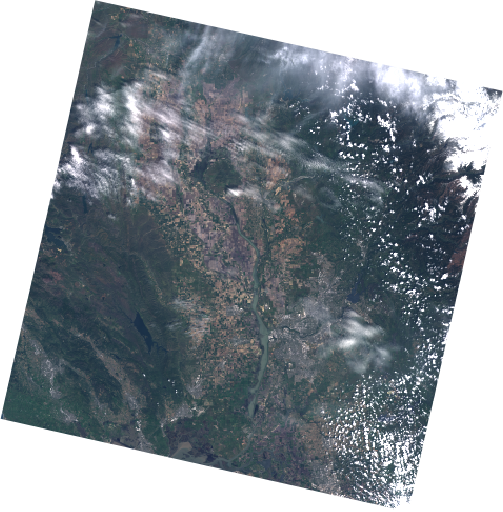

In [211]:
landsat_id = landsat_id_list[1]
#landsat_id = 'LC08_044033_20170716'
print(landsat_id)
landsat_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/{}'.format(landsat_id))
Image(url=landsat_img.select([3, 2, 1]).getThumbURL({'min': 0.0, 'max': 0.3}),
      embed=True, format='png')

B3 refers to the images Landsat Band Designation: https://landsat.usgs.gov/what-are-band-designations-landsat-satellites, B3 being near infared.

In [212]:
landsat_cs = 30
landsat_crs = landsat_img.select('B3').projection().getInfo()['crs']
landsat_region = landsat_img.geometry().bounds(1, 'EPSG:4326').coordinates().getInfo()
landsat_dt = ee.Date(landsat_img.get('system:time_start'))

In [213]:
ssebop_obj = ssebop.Image.from_landsat_c1_toa(landsat_img)

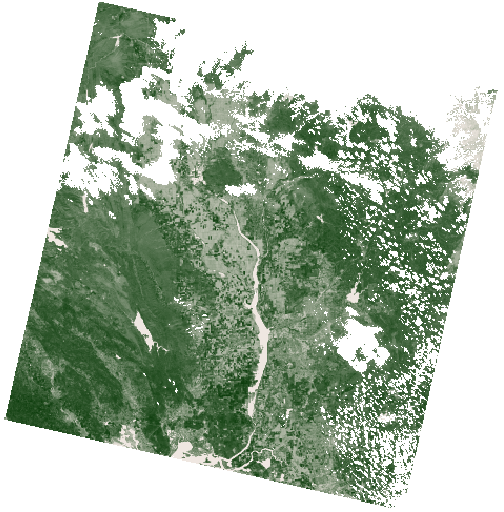

In [214]:
Image(url=ssebop_obj.ndvi.getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ','.join(ndvi_palette)}),
      embed=True, format='png')

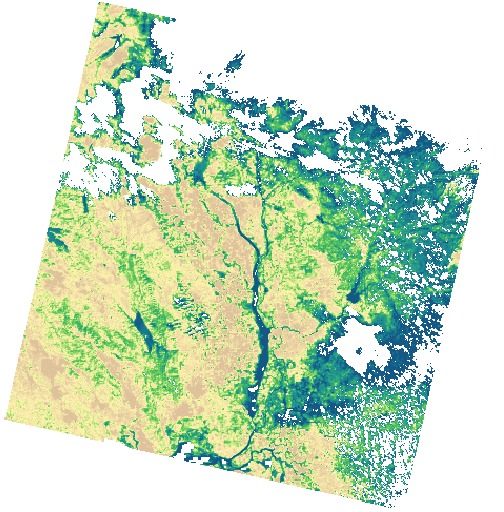

In [ ]:
Image(url=ssebop_obj.etf.getThumbURL({'min': 0.0, 'max': 1.2, 'palette': ','.join(et_palette)}),
      embed=True, format='png')

In [ ]:
etr_img = ee.Image(ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').select(['etr'])\
    .filterDate(landsat_dt, landsat_dt.advance(1, 'day'))\
    .first())

# Clip and project to the Landsat image footprint and coordinate system
Image(url=etr_img.reproject(crs=landsat_crs, scale=landsat_cs)\
          .getThumbURL({'min': 0.0, 'max': 15, 'palette': ','.join(et_palette), 
                        'region': landsat_region}),
      embed=True, format='png')